<a href="https://colab.research.google.com/github/softClaws/Malaria_Diagnosis/blob/main/malariaDiagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Normalization, MaxPool2D, Resizing, Rescaling, Flatten, InputLayer, Dense, BatchNormalization, Dropout
from google.colab import drive

**DATA FETCHING AND SPLITTING**

In [2]:
dataset, dataset_info = tfds.load('malaria', with_info = True, as_supervised = True, shuffle_files = True, split = ['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteBJB30F/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
dataset_info



tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmpw_lh1utptfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},


In [3]:
for data in dataset[0].take(4):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(115, 157, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [3]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE =len(dataset)
  train_dataset = dataset.take(int(DATASET_SIZE * TRAIN_RATIO))
  val_test = dataset.skip(int(DATASET_SIZE * TRAIN_RATIO))
  val_dataset = val_test.take(int(DATASET_SIZE * VAL_RATIO))
  test_dataset = val_test.take(int(DATASET_SIZE * VAL_RATIO))
  return train_dataset, val_dataset, test_dataset

In [4]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.2
TEST_RATIO = 0.2

In [5]:
train_dataset, val_dataset, test_dataset = splits(dataset[0],TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [ ]:
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()),
      list(test_dataset.take(1).as_numpy_iterator()),)

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

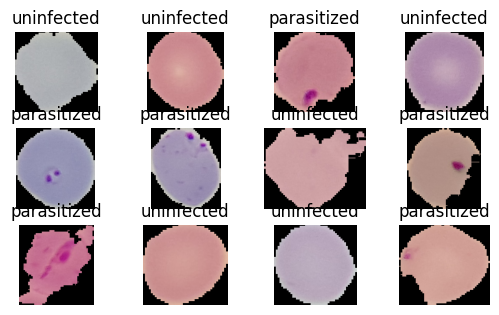

In [ ]:
for i, (image,label) in enumerate(train_dataset.take(12)):
  axis = plt.subplot(4,4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features["label"].int2str(label))
  plt.axis('off')

In [ ]:
dataset_info.features["label"].int2str(1)

'uninfected'

**DATA** **PROCESSING**

In [6]:
IMG_SIZE = 244

In [7]:
resizing_rescaling_layer = Sequential([
    Resizing(IMG_SIZE, IMG_SIZE),
    Rescaling(scale=1./255)
])

In [8]:
def resize_rescale(image, label):
  return tf.image.resize(image, (IMG_SIZE, IMG_SIZE))/255.0, label

In [9]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [11]:
for image, label in train_dataset.take(1):
  print(image,label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(244, 244, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [10]:
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration= True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration= True).batch(32).prefetch(tf.data.AUTOTUNE)

In [11]:
model_1 = Sequential([
    InputLayer(input_shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(filters = 16,kernel_size = 3,strides=1,padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides =2),
    BatchNormalization(),

    Conv2D(filters = 6,kernel_size = 3,strides=1,padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides =2),
    Dropout(0.3),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation= "relu"),
    BatchNormalization(),
    Dense(64, activation= "relu"),
    Dropout(0.3),

    BatchNormalization(),
    Dense(32, activation= "relu"),
    BatchNormalization(),
    Dense(1, activation = "sigmoid")

    ])

In [ ]:
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 242, 242, 16)      448       
                                                                 
 batch_normalization_9 (Bat  (None, 242, 242, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 121, 121, 16)      0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Ba  (None, 121, 121, 16)      64        
 tchNormalization)                                               
                                                                 
 dropout (Dropout)           (None, 121, 121, 16)      0         
                                                      

In [12]:

model_1.compile(optimizer= Adam(learning_rate =0.01),
                loss = BinaryCrossentropy(),
                metrics = 'accuracy'
                )

In [13]:
history = model_1.fit(train_dataset, validation_data =val_dataset, epochs = 10, verbose =1)

Epoch 1/10
689/689 [==============================] - 75s 86ms/step - loss: 0.3717 - accuracy: 0.8353 - val_loss: 1.0489 - val_accuracy: 0.8218
Epoch 2/10
689/689 [==============================] - 59s 86ms/step - loss: 0.3003 - accuracy: 0.8908 - val_loss: 0.5705 - val_accuracy: 0.5028
Epoch 3/10
689/689 [==============================] - 59s 86ms/step - loss: 0.2795 - accuracy: 0.9032 - val_loss: 0.5508 - val_accuracy: 0.5055
Epoch 4/10
689/689 [==============================] - 58s 84ms/step - loss: 0.2254 - accuracy: 0.9268 - val_loss: 0.3234 - val_accuracy: 0.9122
Epoch 5/10
689/689 [==============================] - 60s 86ms/step - loss: 0.2135 - accuracy: 0.9294 - val_loss: 0.8240 - val_accuracy: 0.5005
Epoch 6/10
689/689 [==============================] - 59s 85ms/step - loss: 0.1898 - accuracy: 0.9389 - val_loss: 5.2740 - val_accuracy: 0.4986
Epoch 7/10
689/689 [==============================] - 64s 92ms/step - loss: 0.1801 - accuracy: 0.9422 - val_loss: 0.2708 - val_accuracy:

In [14]:
test_dataset = test_dataset.batch(1)

In [15]:
model_1.evaluate(test_dataset)

5511/5511 [==============================] - 32s 4ms/step - loss: 0.1901 - accuracy: 0.9365


[0.19007407128810883, 0.9364906549453735]

In [18]:
parasite_or_not(model_1.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 9s 9s/step


'P'

In [17]:
def parasite_or_not(x):
  if(x < 0.5):
    return str('P')
  else:
    return str('U')


1/1 [==============================] - 10s 10s/step


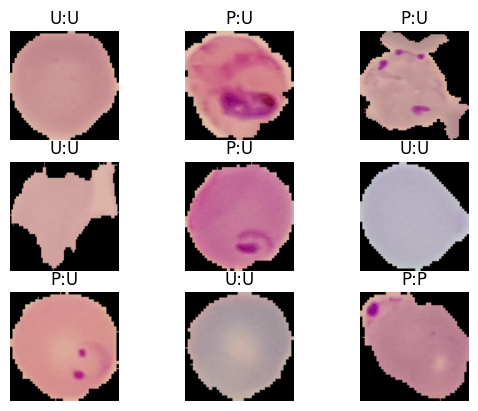

In [19]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model_1.predict(test_dataset.take(1))[0][0])))
  plt.axis("off")

In [20]:
model_1.save("MalariaDiag_seq")

In [21]:
model_loaded = tf.keras.models.load_model("MalariaDiag_seq")
model_loaded.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 242, 242, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 242, 242, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 121, 121, 16)      0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 121, 121, 16)      64        
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 119, 119, 6)       870       
                                                      

In [ ]:
drive.mount('content/drive/')